<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/alldata/Replicate_GCP1_main_conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data/all_data

Mounted at /content/drive
/content/drive/MyDrive/GCP_data/all_data


In [3]:
!pip uninstall -y gcpdatautils
!pip install git+https://github.com/AvantiShri/gcpdatautils.git

  Cloning https://github.com/AvantiShri/gcpdatautils.git to /tmp/pip-req-build-__5bhiwx
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-__5bhiwx
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit 175ed72924dbe57a7ec920341a2dcc015a584fb1
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.0.0-py3-none-any.whl size=5880 sha256=e969c637388f2504a58fe7036fa312d2dc5e45bacbb41dbd0013eb1a19c7fd04
  Stored in directory: /tmp/pip-ephem-wheel-cache-ig8rt93f/wheels/fe/f9/b7/d5afa50c9e111dcf3a66edb57f0c2273e54d108591664596b8
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=521c249d19a19fab15ac4e1efac33c8c8676b3a9ba1ceaa03ed3a8839845d4d3
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built gcpdatautils bs4


In [4]:
from gcpdatautils import parse_events_html

#download the formal event registry and read the events in
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

included_events = parse_events_html("/content/drive/MyDrive/GCP_data/pred_formal.html", exclude_events_longer_than_days=7)

--2023-12-20 09:02:13--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [ <=>                ] 184.64K  1.12MB/s    in 0.2s    

2023-12-20 09:02:13 (1.12 MB/s) - ‘pred_formal.html’ saved [189067]

Skipping because event is more than 7 days long! 25 Pray for Peace 1999-04-03 20:00:00 1999-05-03 19:01:59
Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because event is more than 7 days long! 51 Kursk, 10 days 2000-08-12 07:28:00 2000-08-21 14:29:59
Skipping because redundant with a corresponding 'mean' event:  65 New Year Var 00-01 2000-12-31 09:30:00 2001-01-01 11:29:59
Skipping because event is more than 7 days long! 79 Buddhist Stu

In [5]:
len(included_events)

492

In [22]:
from gcpdatautils import GCPMissingDataError, ROTTEN_EGGS, parse_rotten_egg_file
from collections import defaultdict
import numpy as np
import h5py

#Instantiate a GCP data reader to read data from the hdf5 files I (Avanti Shrikumar) prepared
class GCPHdf5DataReader(object):

  def __init__(self, bad_data_file=ROTTEN_EGGS,
                     year_to_hdf5path=lambda x: "GCP1data_"+str(x)+".hdf5"):
    print("Parsing the bad data file:",bad_data_file)
    #reorganize the bad data list by device ID
    self.bad_data_lookup = defaultdict(list)
    for baddata_starttime, baddata_endtime, deviceid in parse_rotten_egg_file(bad_data_file):
      self.bad_data_lookup[deviceid].append((baddata_starttime, baddata_endtime))
    self.year_to_hdf5fh = {} #mapping from the year to the hdf5 file handle
    self.year_to_hdf5path = year_to_hdf5path

  def fetch_data(self, starttime, endtime, normalize=False):

    if (endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")):
      return self.fetch_data_within_day_normalize(starttime, endtime, normalize=normalize) #returns both data and devices
    else:
      #split into accesses over multiple days
      start_day = starttime.strftime("%Y-%m-%d")
      end_day = endtime.strftime("%Y-%m-%d")
      #for the first day:
      day_accesses = [ (
          starttime,
          datetime.strptime(start_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')) ]
      #for intermediate days:
      dayoffset = 1
      inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")
      while inter_day != end_day:
        day_accesses.append(
            (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
             datetime.strptime(inter_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')))
        dayoffset += 1
        inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")

      #for the final day
      day_accesses.append(
          (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
           endtime))
      days_data_and_devices = [self.fetch_data_within_day_normalize(t1, t2, normalize=normalize) for (t1,t2) in day_accesses]
      #if all the days have the same sets of devices...
      if (len(set([str(x[1]) for x in days_data_and_devices]))==1):
        return np.concatenate([x[0] for x in days_data_and_devices], axis=0), days_data_and_devices[0][1]
      else:
        #print("Some days don't have same devices. Rearranging")
        all_devices = set()
        [all_devices.update(x[1]) for x in days_data_and_devices]
        all_devices = sorted(all_devices)
        all_devices_newidxs = dict([(x[1],x[0]) for x in enumerate(all_devices)])
        rearranged_days_data = []
        for day_data, day_devices in days_data_and_devices:
          rearranged_day_data = np.zeros((len(day_data), len(all_devices)))
          rearranged_day_data[:,:] = np.nan
          for orig_deviceidx, deviceid in enumerate(day_devices):
            rearranged_day_data[:,all_devices_newidxs[deviceid]] = day_data[:,orig_deviceidx]
          rearranged_days_data.append(rearranged_day_data)
        return np.concatenate(rearranged_days_data, axis=0), all_devices

  def fetch_data_within_day_normalize(self, starttime, endtime, normalize):
    day = starttime.strftime("%Y-%m-%d")
    day_start = datetime.strptime(day+" 00:00:00", '%Y-%m-%d %H:%M:%S')
    day_end = datetime.strptime(day+" 23:59:59", '%Y-%m-%d %H:%M:%S')
    full_day_data, daydevices = self.fetch_data_within_day(day_start, day_end)
    if (normalize==False):
      return full_day_data, daydevices
    else:
      device_day_stdevs = np.nan_to_num(np.nanstd(full_day_data, axis=0), np.sqrt(50))
      device_day_means = np.nan_to_num(np.nanmean(full_day_data, axis=0), 100)
      #transform the data to be centered around 100, with stdev of sqrt(50)
      full_day_data_normalized = ((full_day_data - device_day_means[None,:])/
                                  (device_day_stdevs[None,:]/np.sqrt(50))) + 100
      start_offset =  int(starttime.timestamp() - day_start.timestamp())
      end_offset = int((endtime.timestamp() - day_start.timestamp()) + 1)
      return full_day_data_normalized[start_offset:end_offset], daydevices

  def fetch_data_within_day(self, starttime, endtime):
    assert endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")
    year = starttime.year
    if (year not in self.year_to_hdf5fh):
      self.year_to_hdf5fh[year] = h5py.File(self.year_to_hdf5path(year), "r")
    fh = self.year_to_hdf5fh[year]
    day = starttime.strftime("%Y-%m-%d")
    if (day not in fh):
      raise GCPMissingDataError("data for "+day+" not present")
    dset = fh[day]
    if dset.attrs['start_time'] > starttime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" starts at "+str(starttime.timestamp())
             +" but data for day starts at "+str(dset.attrs['start_time']))
    if dset.attrs['end_time'] < endtime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" ends at "+str(endtime.timestamp())
             +" but data for day ends at "+str(dset.attrs['end_time']))
    #now that we have verified that the day has all the data we need...
    start_offset = int(starttime.timestamp() - dset.attrs['start_time'])
    end_offset = int(endtime.timestamp()+1 - dset.attrs['start_time']) #add +1 since GCP ranges are end-inclusive
    day_data = np.array(dset[start_offset:end_offset]).astype("float")
    #replace 255 with nan
    day_data[day_data==255] = np.nan

    #Mask out columns with bad data
    masking_occurred = False
    devices_on_day = fh[day].attrs["device_ids"]
    for deviceid_idx,deviceid in enumerate(devices_on_day):
      if (deviceid in self.bad_data_lookup):
        for rottenegg_start, rottenegg_end in self.bad_data_lookup[deviceid]:
          if (rottenegg_start.timestamp() <= endtime.timestamp() and rottenegg_end.timestamp() >= starttime.timestamp()):
            if (masking_occurred == False):
              print("Before masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)),"for",starttime,"to",endtime)
            masking_occurred = True
            print("Found 'rotten egg' entries for device id:",deviceid,
                  "in time range",starttime,"to",endtime,
                  "(range:",rottenegg_start,"to",rottenegg_end,")")
            mask_startidx = int(max(rottenegg_start.timestamp()-starttime.timestamp(),0))
            mask_endidx = int(min((rottenegg_end.timestamp()+1)-starttime.timestamp(), len(day_data))) #+1 because end inclusive
            day_data[mask_startidx:mask_endidx, deviceid_idx] = np.nan

    if (masking_occurred):
      print("After masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)))
    #Check that there are no rows that completely lack data
    nonnan_devices_per_second = np.sum(np.isnan(day_data)==False, axis=1)
    if (np.min(nonnan_devices_per_second)==0):
      raise GCPMissingDataError("Some seconds for query from "+str(starttime)+" to "+str(endtime)+" had no data")

    return day_data, devices_on_day

  def __exit__(self, exc_type, exc_value, traceback):
    self.close()

  def close(self):
    for fh in self.year_to_hdf5fh.values():
      fh.close()

gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


In [25]:
from datetime import datetime,timedelta
import numpy as np
import h5py
import traceback
import scipy


def compare_different_calc_approaches(egg_values, blocksizes):
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row

  egg_zscores = (egg_values - 100)/np.sqrt(50)

  pvaltozs_sumthensquare = []
  pvaltozs_squarethensum = []
  for blocksize in blocksizes:
    num_blocks = int((len(egg_zscores) - (len(egg_zscores)%blocksize))/blocksize)
    num_eggs = egg_zscores.shape[-1]
    blockreshaped_eggzscores = egg_zscores[0 : blocksize*num_blocks].reshape(num_blocks, blocksize, num_eggs)

    perblock_peregg_zsums = np.sum(blockreshaped_eggzscores, axis=1)/np.sqrt(blocksize) #shape becomes (num_blocks x num_eggs), nan if any value in the block is nan
    num_nonnan_eggblocks = np.sum(np.isnan(perblock_peregg_zsums)==False, axis=-1) #shape is num_blocks

    #compute p value if we sum across eggs first, then square
    perblock_zsums = np.nansum(perblock_peregg_zsums, axis=1)/np.maximum(np.sqrt(num_nonnan_eggblocks), 1) #shape becomes num_blocks
    pvaltoz_sumthensquare = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(x=np.nansum(np.square(perblock_zsums)), df=np.sum(num_nonnan_eggblocks > 0)))
    pvaltozs_sumthensquare.append(pvaltoz_sumthensquare)

    #compute p value if we square first, then sum across eggs and timesteps
    pvaltoz_squarethensum = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(np.nansum(np.square(perblock_peregg_zsums)),
                                                  df=np.sum(num_nonnan_eggblocks)))
    #the above code sometimes returns cdfs of 1.0, so we will also use the normal approx and take the less significant of the two
    pvaltoz_squarethensum = min(pvaltoz_squarethensum,
                                np.nansum(np.square(perblock_peregg_zsums)-1)/np.sqrt(2*np.sum(num_nonnan_eggblocks)) )
    pvaltozs_squarethensum.append(pvaltoz_squarethensum)

  return pvaltozs_sumthensquare, pvaltozs_squarethensum


BLOCKSIZES = [1]#, 2, 3, 6, 8, 10, 15]
all_pvaltozs_sumthensquare = []
all_pvaltozs_squarethensum = []

control_timeshifts = [-2]#-50, -10, -4, -3, -2, -1, 1, 2, 3, 4, 10, 50]

controls_all_pvaltozs_sumthensquare = dict([(x,[]) for x in control_timeshifts])
controls_all_pvaltozs_squarethensum = dict([(x,[]) for x in control_timeshifts])

surviving_events = [] #in case we encounter missing data errors
#read the data for the events

eventcount = 0

for (event_num, event_name, start_datetime, end_datetime, duration) in included_events[:]:
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:
    event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=True)[0]
    event_pvaltozs_sumthensquare, event_pvaltozs_squarethensum = compare_different_calc_approaches(event_data, BLOCKSIZES)
    print("Event data: Sum then square:", event_pvaltozs_sumthensquare)
    print("Event data: Square then sum:", event_pvaltozs_squarethensum)

    print("For controls...")
    thisevent_control_pvaltozs_sumthensquare = {}
    thisevent_control_pvaltozs_squarethensum = {}
    for control_timeshift in control_timeshifts:
      timeshift = timedelta(seconds=control_timeshift*duration)
      control_starttime = start_datetime + timeshift
      control_endtime = end_datetime + timeshift
      print("Control start and end:", control_starttime, control_endtime)
      control_data = gcp_data_reader.fetch_data(control_starttime, control_endtime, normalize=True)[0]
      pvaltozs_sumthensquare, pvaltozs_squarethensum = compare_different_calc_approaches(control_data, BLOCKSIZES)
      print("Control data: Sum then square:", pvaltozs_sumthensquare)
      print("Control data: Square then sum:", pvaltozs_squarethensum)
      thisevent_control_pvaltozs_sumthensquare[control_timeshift] = pvaltozs_sumthensquare
      thisevent_control_pvaltozs_squarethensum[control_timeshift] = pvaltozs_squarethensum

    all_pvaltozs_sumthensquare.append(event_pvaltozs_sumthensquare)
    all_pvaltozs_squarethensum.append(event_pvaltozs_squarethensum)
    for control_timeshift in control_timeshifts:
      controls_all_pvaltozs_sumthensquare[control_timeshift].append(
          thisevent_control_pvaltozs_sumthensquare[control_timeshift])
      controls_all_pvaltozs_squarethensum[control_timeshift].append(
          thisevent_control_pvaltozs_squarethensum[control_timeshift])
    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)


EVENT COUNT 1
1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
Event data: Sum then square: [1.5010443666079536]
Event data: Square then sum: [1.0494911714734434]
For controls...
Control start and end: 1998-08-07 01:15:00 1998-08-07 04:14:59
Control data: Sum then square: [0.05075441653085224]
Control data: Square then sum: [0.333757377988068]
EVENT COUNT 2
1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
Event data: Sum then square: [1.5010443666079536]
Event data: Square then sum: [1.0494911714734434]
For controls...
Control start and end: 1998-08-07 01:15:00 1998-08-07 04:14:59
Control data: Sum then square: [0.05075441653085224]
Control data: Square then sum: [0.333757377988068]
EVENT COUNT 3
3 Bomb Afghanistan 1998-08-20 17:15:00 1998-08-20 17:44:59 1800.0
Event data: Sum then square: [-0.4115808013918078]
Event data: Square then sum: [0.01918114304930927]
For controls...
Control start and end: 1998-08-20 16:15:00 1998-08-20 16:44:59
Control data: Sum then square

<ipython-input-22-fe41438f4e82>:73: RuntimeWarning: Mean of empty slice
  device_day_means = np.nan_to_num(np.nanmean(full_day_data, axis=0), 100)


Event data: Sum then square: [0.852600250740482]
Event data: Square then sum: [1.7542169447065081]
For controls...
Control start and end: 1998-12-10 21:30:00 1998-12-10 22:29:59
Before masking, fraction of nans in raw data is 0.15488095238095237 for 1998-12-10 00:00:00 to 1998-12-10 23:59:59
Found 'rotten egg' entries for device id: 1005 in time range 1998-12-10 00:00:00 to 1998-12-10 23:59:59 (range: 1998-12-10 00:00:00 to 1998-12-17 23:59:59 )
After masking, fraction of nans in raw data is 0.15585482804232803
Control data: Sum then square: [-2.2019929529236943]
Control data: Square then sum: [-0.9118007510450482]
EVENT COUNT 12
12 Iraq Bombing 1998-12-16 21:30:00 1998-12-16 22:29:59 3600.0
Before masking, fraction of nans in raw data is 0.029133597883597883 for 1998-12-16 00:00:00 to 1998-12-16 23:59:59
Found 'rotten egg' entries for device id: 1005 in time range 1998-12-16 00:00:00 to 1998-12-16 23:59:59 (range: 1998-12-10 00:00:00 to 1998-12-17 23:59:59 )
After masking, fraction of

num events after dropping events with missing data: 487



Blocksize: 1 seconds
************TEST TYPE: actual
Meta-analysis Z-score if squaring *after* summing: 5.922489567281981 pval: 1.5855196044967101e-09
Meta-analysis Z-score if squaring *before* summing 1.3952069129751148 pval:  0.08147672649368043
Argmax event for square after summing: ('487', 'September 21', datetime.datetime(2014, 9, 21, 0, 0), datetime.datetime(2014, 9, 21, 23, 59, 59), 86400.0) 3.334830711227354
Argmax event for square before summing: ('271', 'Obama Acceptance 080828', datetime.datetime(2008, 8, 29, 2, 0), datetime.datetime(2008, 8, 29, 3, 59, 59), 7200.0) 3.2790850998672973
Correlation between the two scores: PearsonRResult(statistic=0.1064465514240082, pvalue=0.01878787021457732)


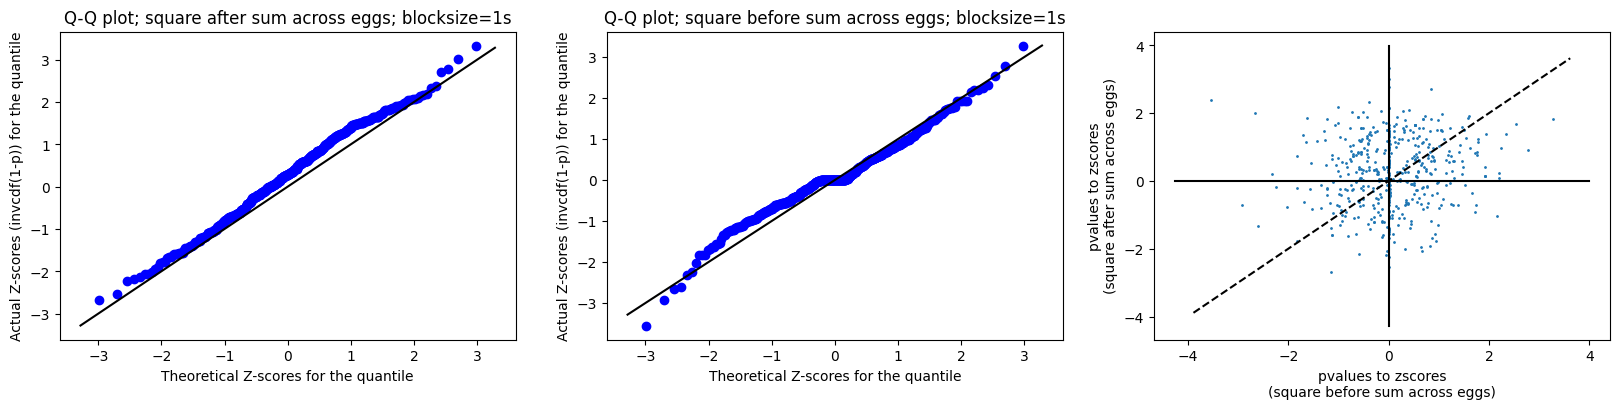

************TEST TYPE: controltimeshift_-2
Meta-analysis Z-score if squaring *after* summing: 0.34551927336453603 pval: 0.3648520116900643
Meta-analysis Z-score if squaring *before* summing 1.7604050552286077 pval:  0.03916957641723007
Argmax event for square after summing: ('434', '12.12.12 Meditation', datetime.datetime(2012, 12, 12, 12, 30), datetime.datetime(2012, 12, 12, 15, 29, 59), 10800.0) 3.6791651663650478
Argmax event for square before summing: ('106', 'Tiger Woods Triumph', datetime.datetime(2002, 4, 14, 18, 22), datetime.datetime(2002, 4, 14, 22, 59, 59), 16680.0) 3.0969715733546344
Correlation between the two scores: PearsonRResult(statistic=0.12199076842667048, pvalue=0.007033443073880503)


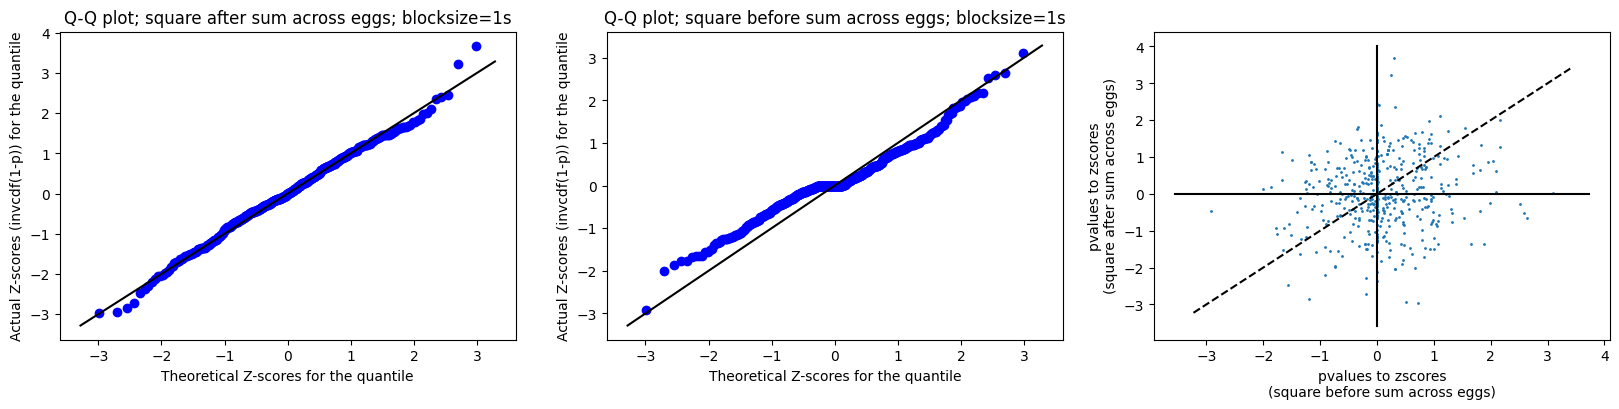

In [27]:
from matplotlib import pyplot as plt

print("num events after dropping events with missing data:", len(surviving_events))

for blocksize_counter, blocksize in enumerate(BLOCKSIZES):
  print("\n\n\nBlocksize:", blocksize, "seconds")

  for (touse_pvaltozs_sumthensquare, touse_pvaltozs_squarethensum, testtype) in (
      [ (all_pvaltozs_sumthensquare, all_pvaltozs_squarethensum, "actual")]
      +[ (controls_all_pvaltozs_sumthensquare[control_timeshift],
          controls_all_pvaltozs_squarethensum[control_timeshift],
          "controltimeshift_"+str(control_timeshift))
         for control_timeshift in control_timeshifts ]):

    print("************TEST TYPE:", testtype)

    for i in range(len(touse_pvaltozs_sumthensquare)):
      if np.isnan(touse_pvaltozs_sumthensquare[i][blocksize_counter]):
        print("Nan warning for event:", surviving_events[i])

    pvaltoz_sumthensquare = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_sumthensquare]) if np.isnan(x)==False]
    pvaltoz_squarethensum = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_squarethensum]) if np.isnan(x)==False]

    metaz_sumthensquare = np.sum(pvaltoz_sumthensquare)/np.sqrt(len(pvaltoz_sumthensquare))
    metaz_squarethensum = np.sum(pvaltoz_squarethensum)/np.sqrt(len(pvaltoz_squarethensum))
    print("Meta-analysis Z-score if squaring *after* summing:", metaz_sumthensquare, "pval:", 1-scipy.stats.norm.cdf(metaz_sumthensquare))
    print("Meta-analysis Z-score if squaring *before* summing", metaz_squarethensum, "pval: ", 1-scipy.stats.norm.cdf(metaz_squarethensum))
    print("Argmax event for square after summing:", surviving_events[np.argmax(pvaltoz_sumthensquare)], np.max(pvaltoz_sumthensquare))
    print("Argmax event for square before summing:", surviving_events[np.argmax(pvaltoz_squarethensum)], np.max(pvaltoz_squarethensum))
    print("Correlation between the two scores:", scipy.stats.pearsonr(pvaltoz_squarethensum, pvaltoz_sumthensquare))

    fig, ax = plt.subplots(ncols=3, figsize=(20,4))
    plt.sca(ax[0])
    scipy.stats.probplot(pvaltoz_sumthensquare, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square after sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[1])
    scipy.stats.probplot(pvaltoz_squarethensum, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square before sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[2])
    plt.scatter(pvaltoz_squarethensum, pvaltoz_sumthensquare, s=1)
    plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--")
    plt.plot(plt.xlim(), [0,0], color="black")
    plt.plot([0,0], plt.ylim(), color="black")
    plt.xlabel("pvalues to zscores\n(square before sum across eggs)")
    plt.ylabel("pvalues to zscores\n(square after sum across eggs)")
    plt.show()